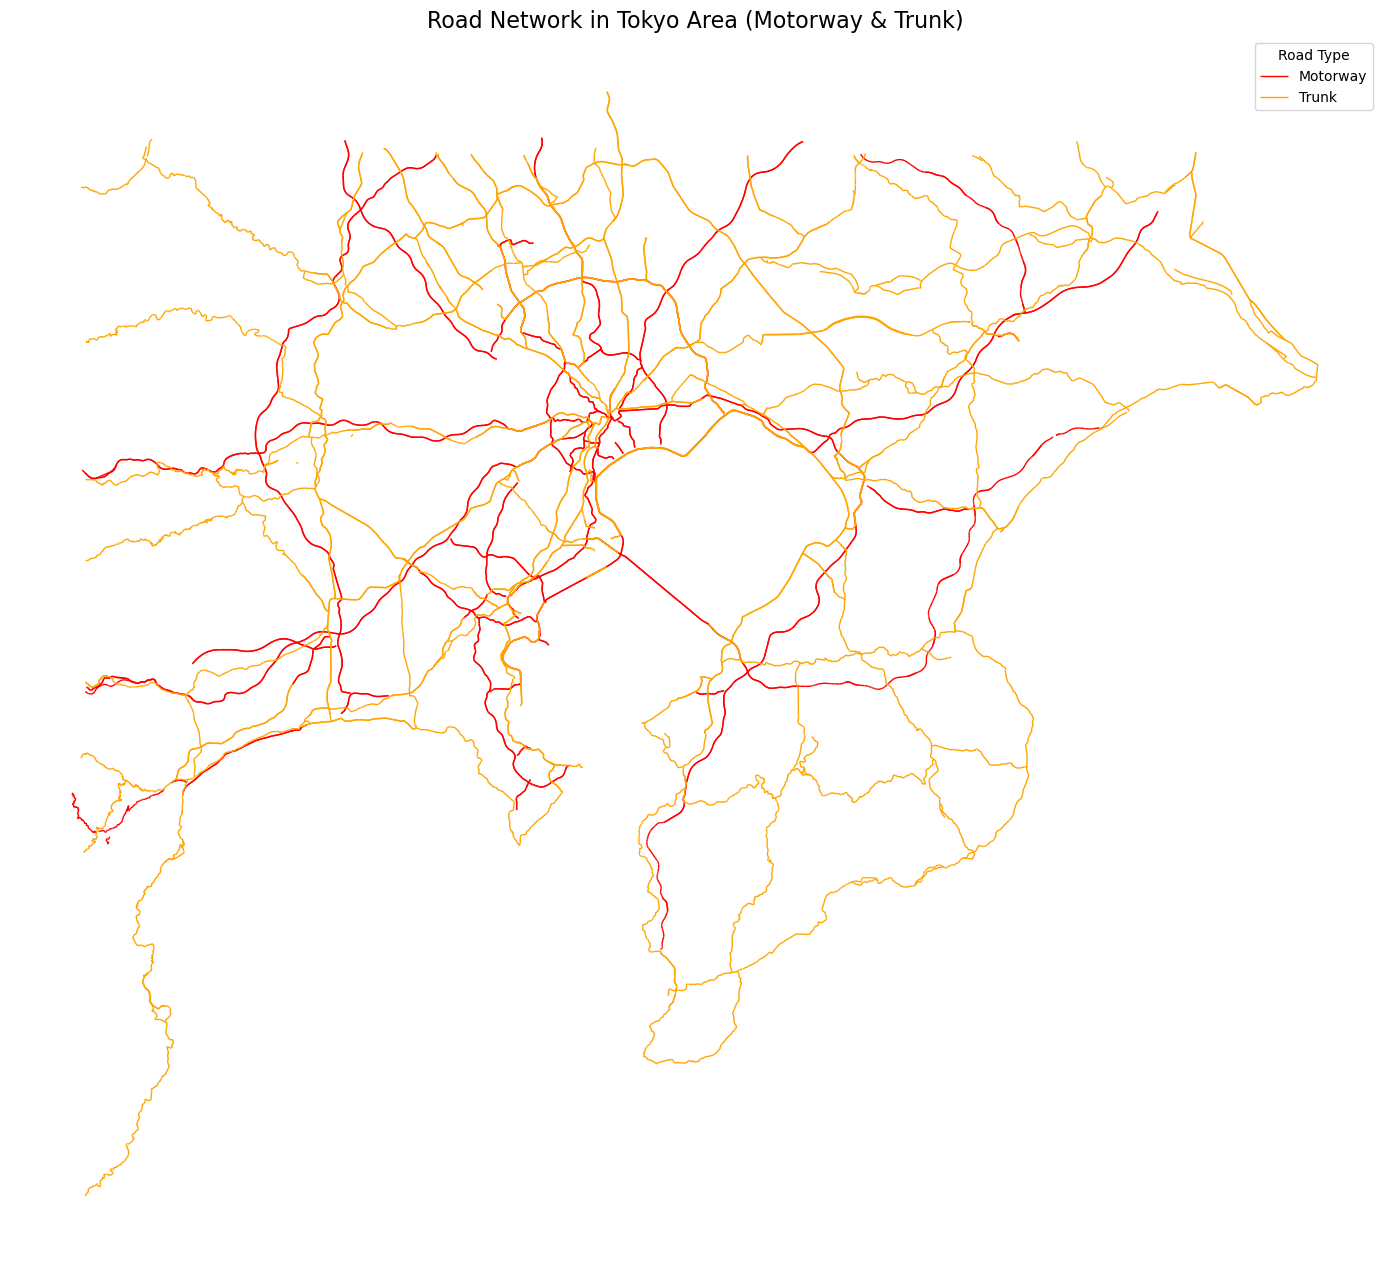

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

geojson_path = "./tokyo_motorway_trunk.geojson"

# 加载数据
gdf = gpd.read_file(geojson_path)

# 分类字段（Motorway / Trunk）
def classify_highway(highway):
    if isinstance(highway, list):
        highway = highway[0]
    if highway == 'motorway':
        return 'Motorway'
    elif highway == 'trunk':
        return 'Trunk'
    else:
        return 'Other'

gdf['type'] = gdf['highway'].apply(classify_highway)

# 设置颜色映射
color_map = {
    'Motorway': 'red',
    'Trunk': 'orange',
    'Other': 'gray'
}
gdf['color'] = gdf['type'].map(color_map)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
for road_type in ['Motorway', 'Trunk']:
    subset = gdf[gdf['type'] == road_type]
    subset.plot(ax=ax, linewidth=1, color=color_map[road_type], label=road_type)

plt.title("Road Network in Tokyo Area (Motorway & Trunk)", fontsize=16)
plt.axis("off")
plt.legend(title="Road Type")
plt.tight_layout()
plt.savefig("tokyo_roads_en.png", dpi=300)  # 可选保存
plt.show()


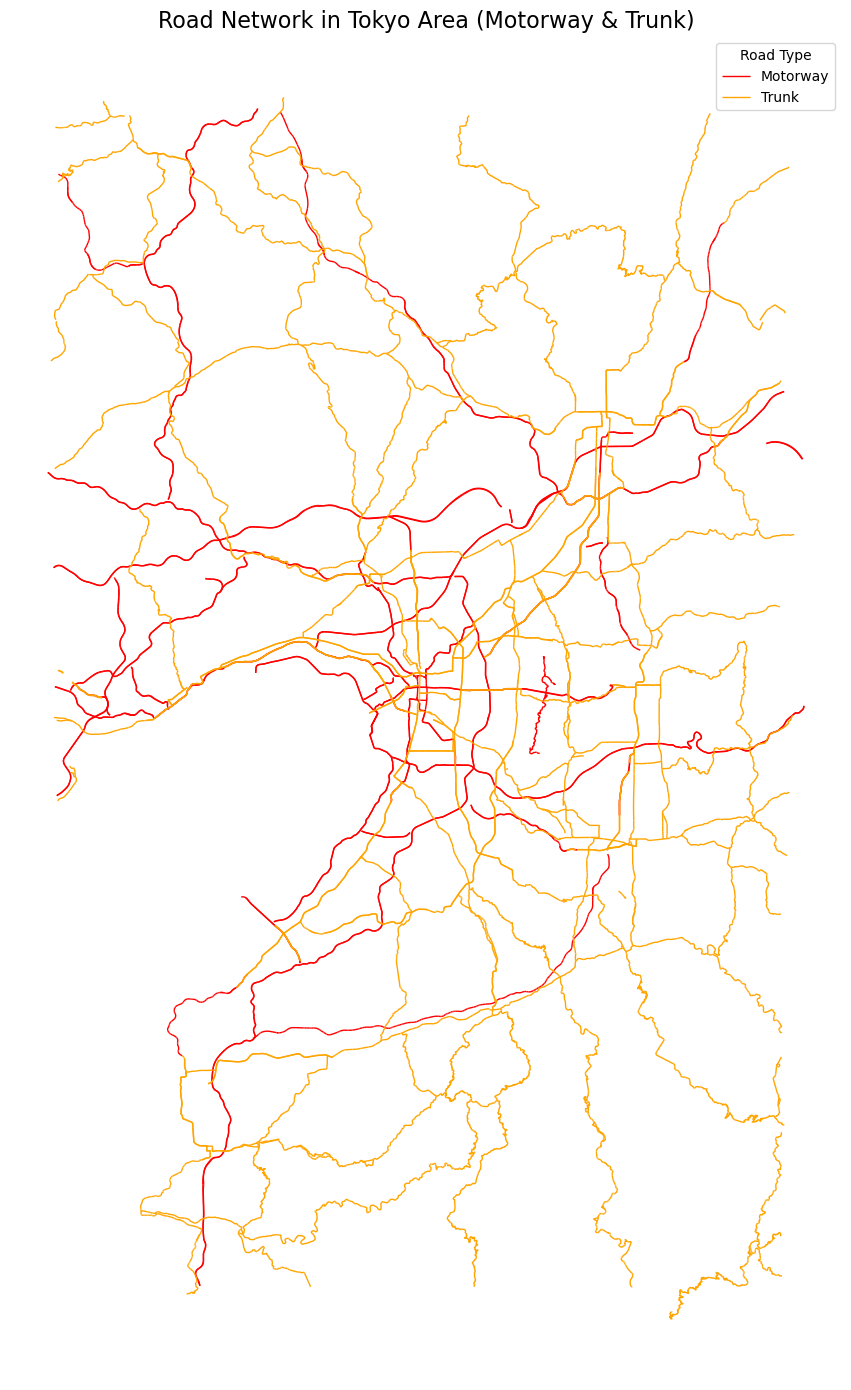

In [9]:

geojson_path = "./keihan_motorway_trunk.geojson"

# 加载数据
gdf = gpd.read_file(geojson_path)


# 分类字段（Motorway / Trunk）
def classify_highway(highway):
    if isinstance(highway, list):
        highway = highway[0]
    if highway == 'motorway':
        return 'Motorway'
    elif highway == 'trunk':
        return 'Trunk'
    else:
        return 'Other'


gdf['type'] = gdf['highway'].apply(classify_highway)

# 设置颜色映射
color_map = {
    'Motorway': 'red',
    'Trunk': 'orange',
    'Other': 'gray'
}
gdf['color'] = gdf['type'].map(color_map)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
for road_type in ['Motorway', 'Trunk']:
    subset = gdf[gdf['type'] == road_type]
    subset.plot(ax=ax, linewidth=1, color=color_map[road_type], label=road_type)

plt.title("Road Network in Tokyo Area (Motorway & Trunk)", fontsize=16)
plt.axis("off")
plt.legend(title="Road Type")
plt.tight_layout()
plt.savefig("keihan_roads_en.png", dpi=300)  # 可选保存
plt.show()


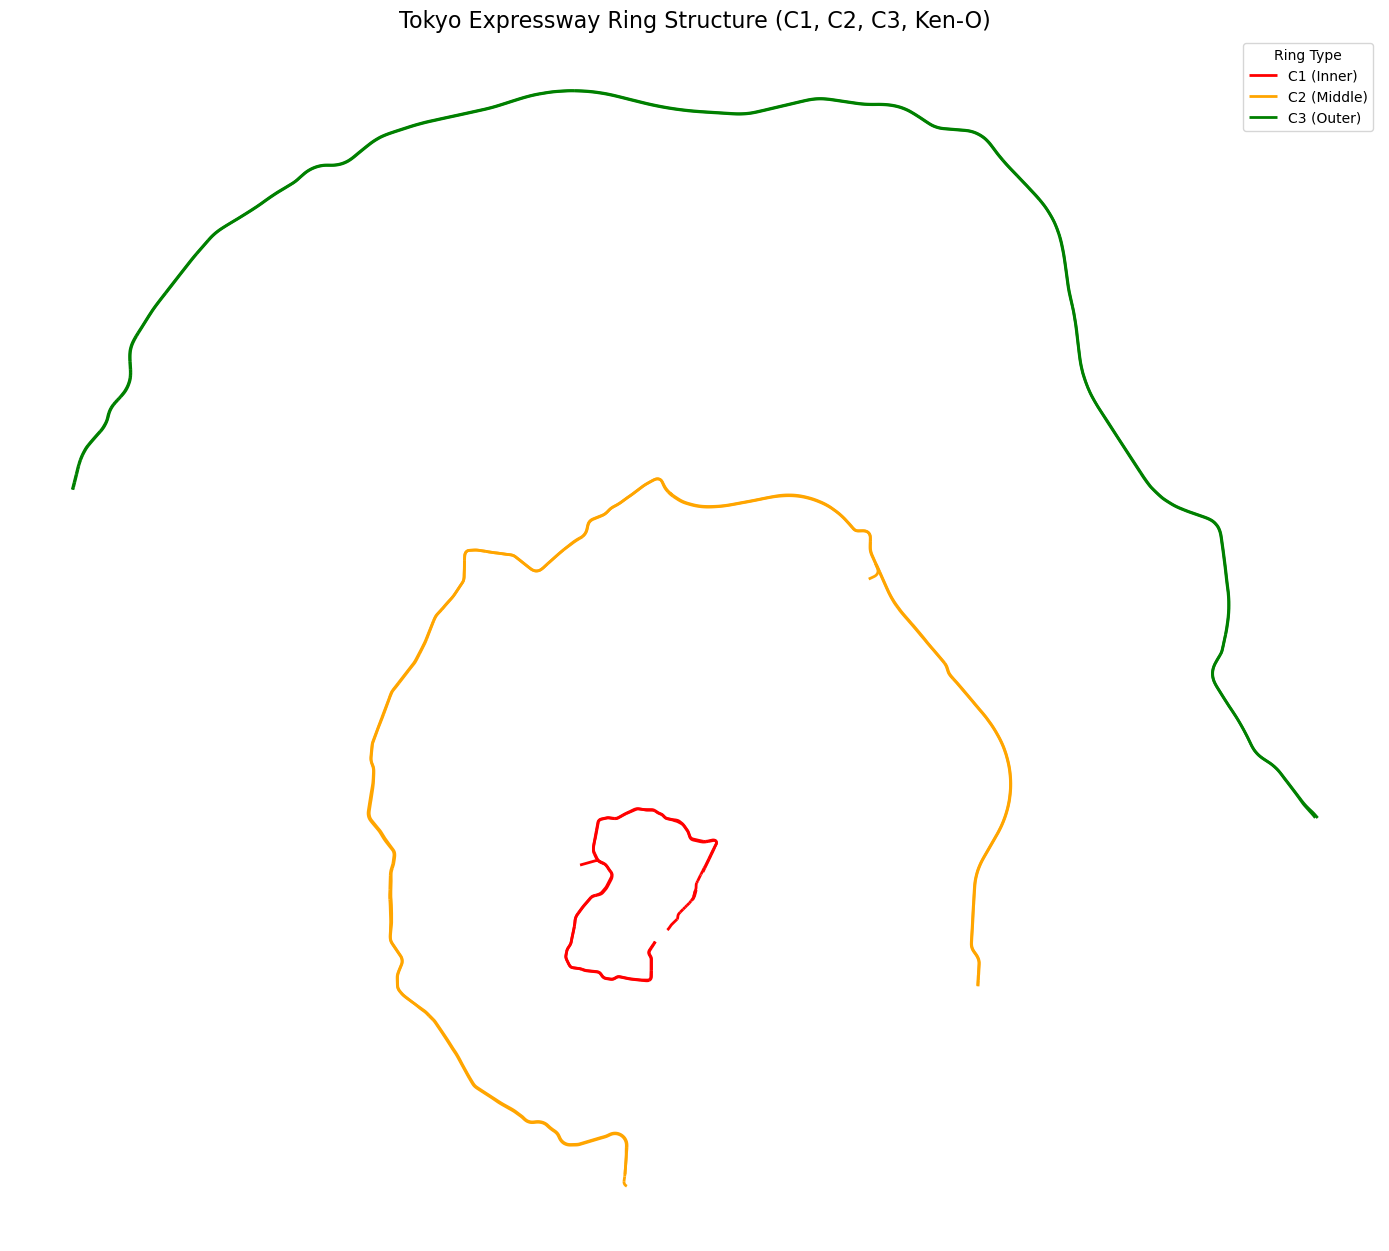

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 文件路径（根据你本地位置）
tokyo_path = "./tokyo_motorway_trunk.geojson"
keno_path = "./keno.geojson"

# 加载东京高速数据（C1~C4）
gdf_tokyo = gpd.read_file(tokyo_path)
gdf_tokyo = gdf_tokyo[gdf_tokyo['ref'].notnull()]  # 删除没有ref的

# 标记 C1 ~ C3
def extract_c_ring(ref_value):
    if isinstance(ref_value, list):
        ref_value = ref_value[0]
    if 'C1' in ref_value:
        return 'C1 (Inner)'
    elif 'C2' in ref_value:
        return 'C2 (Middle)'
    elif 'C3' in ref_value:
        return 'C3 (Outer)'
    else:
        return None

gdf_tokyo['ring_type'] = gdf_tokyo['ref'].apply(extract_c_ring)
gdf_tokyo = gdf_tokyo[gdf_tokyo['ring_type'].notnull()]  # 保留C1~C3

# 指定颜色映射
color_map = {
    'C1 (Inner)': 'red',
    'C2 (Middle)': 'orange',
    'C3 (Outer)': 'green',
    'Ken-O (Metropolitan)': 'blue'
}
gdf_tokyo['color'] = gdf_tokyo['ring_type'].map(color_map)

# 加载 Ken-O 数据（没有 ref 字段，我们手动添加标签）
gdf_keno = gpd.read_file(keno_path)
gdf_keno = gdf_keno[gdf_keno.geometry.notnull()]  # 删除空几何
gdf_keno['ring_type'] = 'Ken-O (Metropolitan)'
gdf_keno['color'] = color_map['Ken-O (Metropolitan)']

# 合并所有数据
gdf_all = gpd.GeoDataFrame(pd.concat([gdf_tokyo, gdf_keno], ignore_index=True), crs=gdf_tokyo.crs)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_aspect("auto")

for ring_type, color in color_map.items():
    subset = gdf_all[gdf_all['ring_type'] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2, color=color, label=ring_type)

plt.title("Tokyo Expressway Ring Structure (C1, C2, C3, Ken-O)", fontsize=16)
plt.axis("off")
plt.legend(title="Ring Type")
plt.tight_layout()
plt.savefig("tokyo_4ring_expressways.png", dpi=300)
plt.show()


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

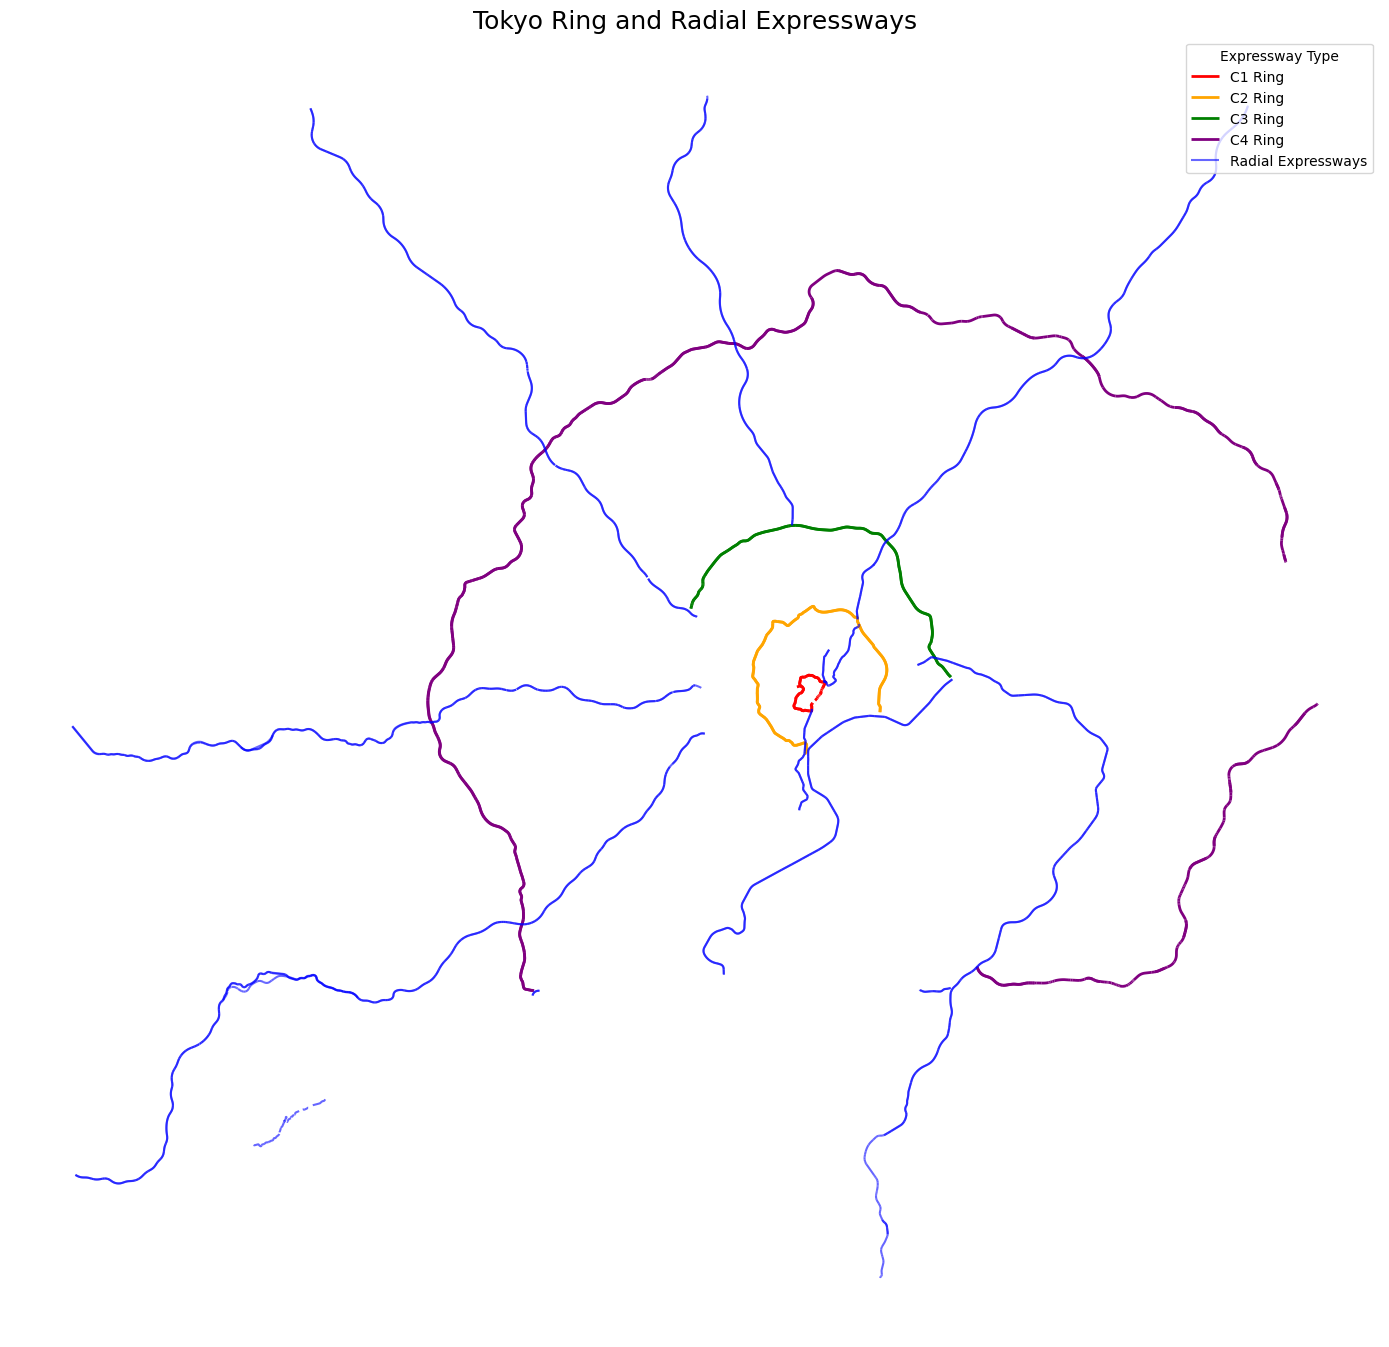

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# === 文件路径 ===
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"

# === 加载数据 ===
gdf_ring = gpd.read_file(ring_path)
gdf_ray = gpd.read_file(ray_path)
gdf_ring = gdf_ring[gdf_ring.geometry.notnull()]
gdf_ray = gdf_ray[gdf_ray.geometry.notnull()]

# === 给四环分配颜色（根据 ref 字段）
def classify_ring(ref):
    if isinstance(ref, list):
        ref = ref[0]
    if "C1" in ref:
        return "C1"
    elif "C2" in ref:
        return "C2"
    elif "C3" in ref:
        return "C3"
    elif "C4" in ref or "Ken-O" in ref or "圏央道" in ref:
        return "C4"
    return "Other"

gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)

# 色彩映射
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# === 绘图 ===
fig, ax = plt.subplots(figsize=(14, 14))

# 绘制环状高速（不同颜色）
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    subset.plot(ax=ax, linewidth=2, color=color, label=f"{ring_type} Ring")

# 绘制放射状高速（统一蓝色）
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6, label="Radial Expressways")

# 图样式
ax.set_title("Tokyo Ring and Radial Expressways", fontsize=18)
ax.set_axis_off()
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
plt.tight_layout()
plt.savefig("tokyo_ring_ray_en.png", dpi=300)
plt.show()


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

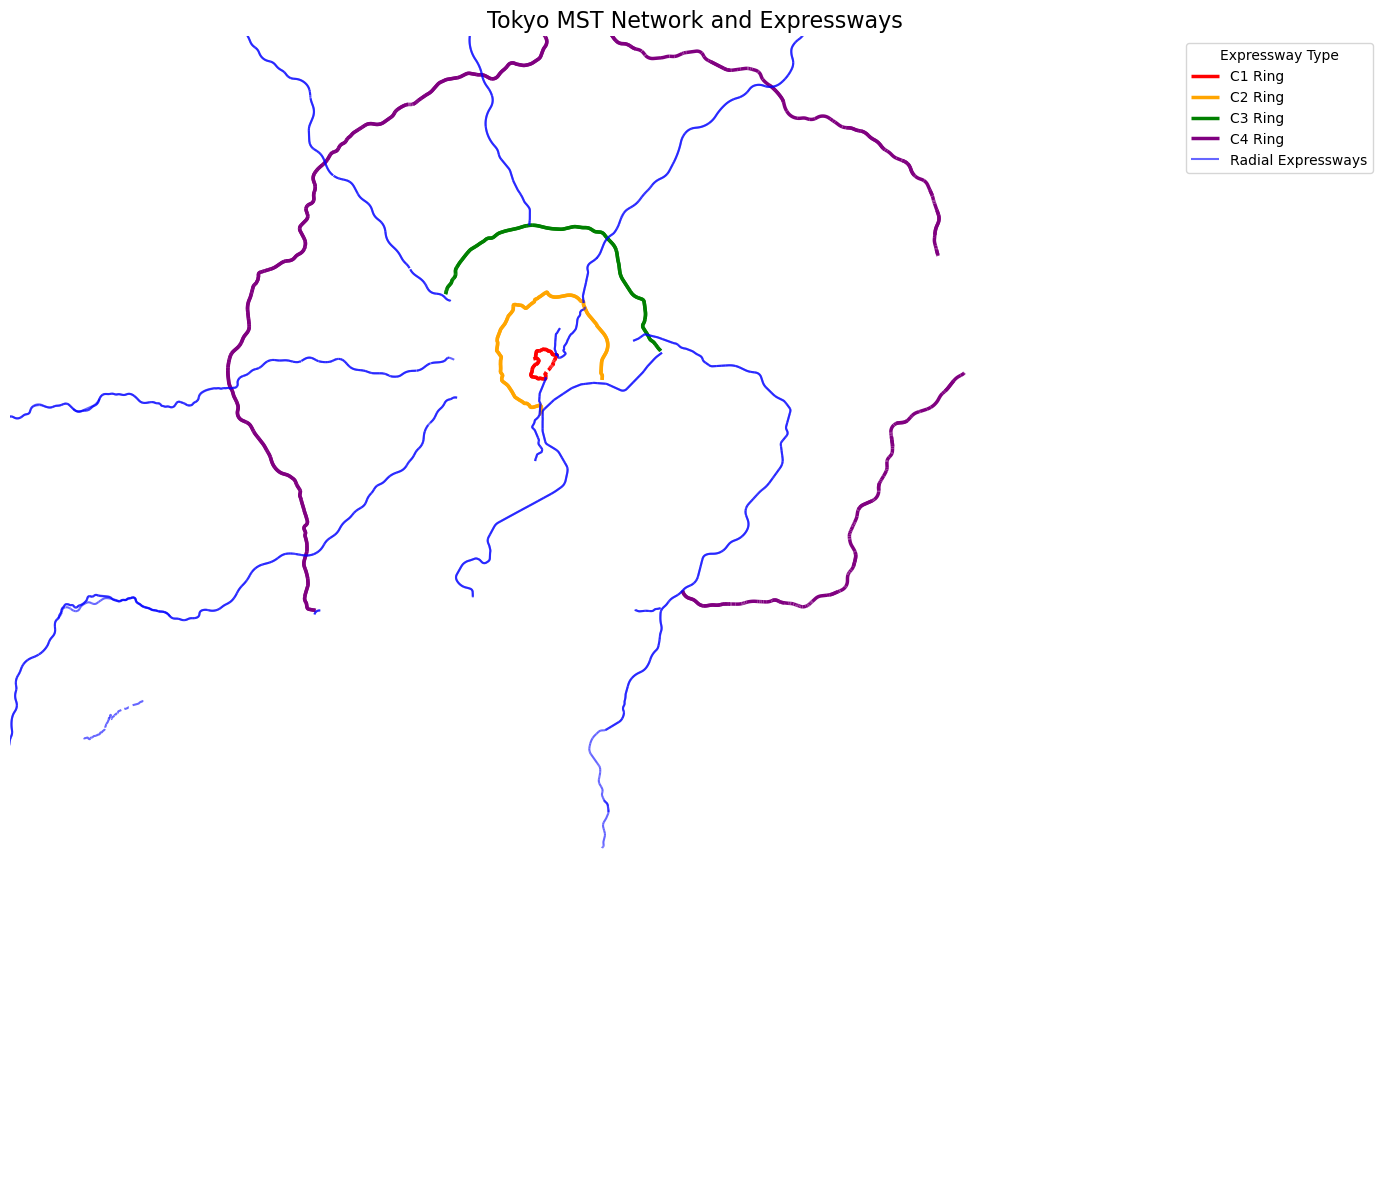

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import python_codes.files_operators as fo  # 自定义 .net 文件读取模块

# ===== 文件路径 =====
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"
mst_path = "./MST_net/tokyo_pop_500_mst.net"

# ===== 加载高速公路 GeoJSON 文件 =====
gdf_ring = gpd.read_file(ring_path)
gdf_ray = gpd.read_file(ray_path)
gdf_ring = gdf_ring[gdf_ring.geometry.notnull()]
gdf_ray = gdf_ray[gdf_ray.geometry.notnull()]

# ===== 分类四环并上色 =====
def classify_ring(ref):
    if isinstance(ref, list):
        ref = ref[0]
    if "C1" in ref:
        return "C1"
    elif "C2" in ref:
        return "C2"
    elif "C3" in ref:
        return "C3"
    elif "C4" in ref or "Ken-O" in ref or "圏央道" in ref:
        return "C4"
    return "Other"

gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# ===== 加载 .net 格式的 MST 网络 =====
read_graph, read_pos_raw = fo.read_files(mst_path)

# ===== 将平面坐标 (0~1000) 映射到东京区域经纬度范围 (2度 × 1.333度) =====
def project_mst_coords_to_latlon(read_pos_raw, graph):
    projected = {}
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])  # ✅ 显式解包 Vector_double
        lon = 139.0 + (x / 1000.0) * 2.0        # 经度方向
        lat = 34.6667 + (y / 1000.0) * 1.3333   # 纬度方向
        projected[v] = (lon, lat)
    return projected

read_pos = project_mst_coords_to_latlon(read_pos_raw, read_graph)

# ===== 开始绘图 =====
fig, ax = plt.subplots(figsize=(14, 14))

# === 绘制环状高速 ===
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2.5, color=color, label=f"{ring_type} Ring")

# === 绘制放射状高速 ===
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6, label="Radial Expressways")

# === 绘制 MST 边（黑色） ===
for edge in read_graph.edges():
    src = read_pos[edge.source()]
    tgt = read_pos[edge.target()]
    ax.plot([src[0], tgt[0]], [src[1], tgt[1]], color="black", linewidth=1.0, zorder=2)

# === 绘制 MST 节点（黑点） ===
for v in read_graph.vertices():
    x, y = read_pos[v]
    ax.scatter(x, y, color="black", s=8, zorder=3)

# === 样式设置 ===
ax.set_title("Tokyo MST Network and Expressways", fontsize=16)
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
ax.set_axis_off()

# === 设置合适的显示范围（东京都 + 周边） ===
ax.set_xlim(138.9, 141.1)
ax.set_ylim(34.6, 36.1)

plt.tight_layout()
plt.savefig("tokyo_mst_ring_ray_overlay_final.png", dpi=300)
plt.show()


In [30]:
# 检查坐标范围
mst_lons = [read_pos[v][0] for v in read_pos]
mst_lats = [read_pos[v][1] for v in read_pos]
print("MST 经度范围：", min(mst_lons), " ~ ", max(mst_lons))
print("MST 纬度范围：", min(mst_lats), " ~ ", max(mst_lats))


MST 经度范围： 141.779  ~  141.898
MST 纬度范围： 36.289992749999996  ~  36.36865745


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

✅ 完成 MST 坐标转换


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

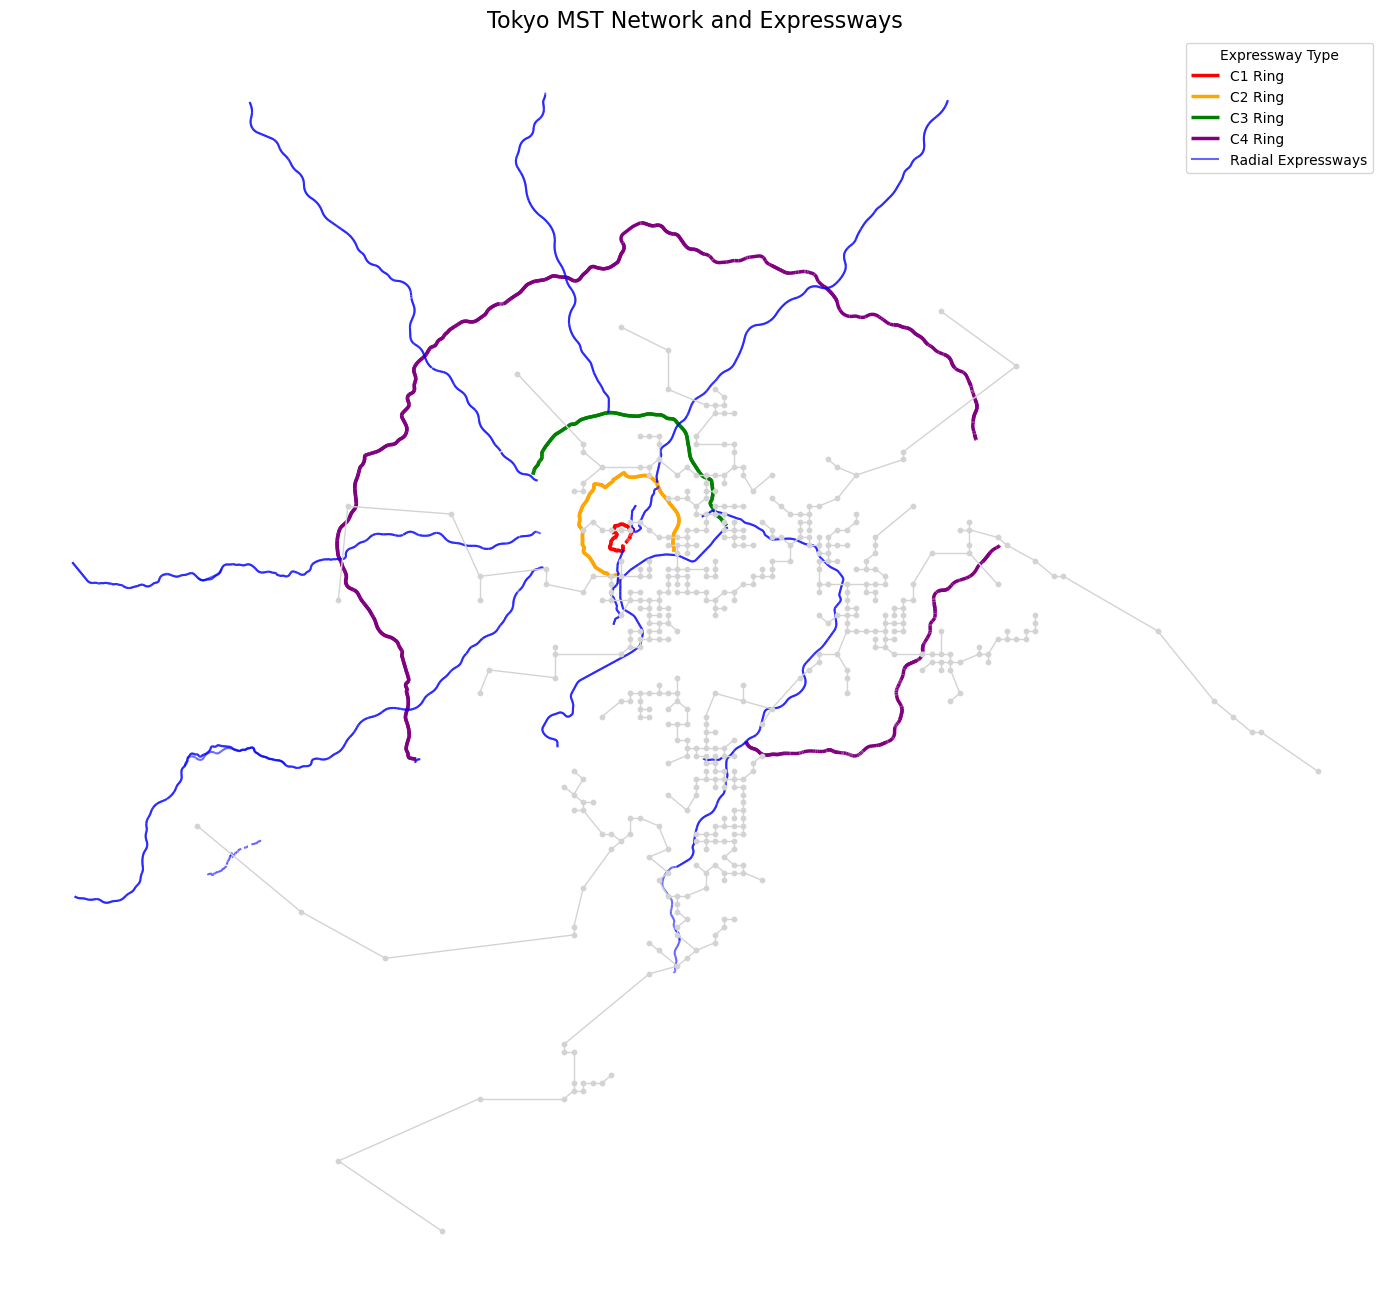

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import python_codes.files_operators as fo

# ===== 文件路径 =====
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"
mst_path = "./MST_net/tokyo_pop_500_mst.net"

# ===== 加载高速公路数据 =====
gdf_ring = gpd.read_file(ring_path)
gdf_ray = gpd.read_file(ray_path)
gdf_ring = gdf_ring[gdf_ring.geometry.notnull()]
gdf_ray = gdf_ray[gdf_ray.geometry.notnull()]

# ===== 高速分类：C1~C4 =====
def classify_ring(ref):
    if isinstance(ref, list):
        ref = ref[0]
    if "C1" in ref:
        return "C1"
    elif "C2" in ref:
        return "C2"
    elif "C3" in ref:
        return "C3"
    elif "C4" in ref or "Ken-O" in ref or "圏央道" in ref:
        return "C4"
    return "Other"

gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# ===== 加载 MST 数据 =====
read_graph, read_pos_raw = fo.read_files(mst_path)

# ===== 自动归一化并上下翻转 Y 轴 → 映射经纬度 =====
def project_mst_coords_to_latlon_flipped(read_pos_raw, graph):
    xs, ys = [], []
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])
        xs.append(x)
        ys.append(y)
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    projected = {}
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])
        x_norm = (x - x_min) / (x_max - x_min)
        y_norm = (y - y_min) / (y_max - y_min)

        lon = 139.0 + x_norm * 2.0
        lat = 34.6667 + (1 - y_norm) * 1.3333  # ✅ Y轴上下颠倒
        projected[v] = (lon, lat)

    print("✅ 完成 MST 坐标转换")
    return projected

read_pos = project_mst_coords_to_latlon_flipped(read_pos_raw, read_graph)

# ===== 开始绘图 =====
fig, ax = plt.subplots(figsize=(14, 14))

# 绘制四环高速
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2.5, color=color, label=f"{ring_type} Ring")

# 绘制放射状高速
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6, label="Radial Expressways")

# ===== 绘制 MST 边 =====
for edge in read_graph.edges():
    src = read_pos[edge.source()]
    tgt = read_pos[edge.target()]
    ax.plot([src[0], tgt[0]], [src[1], tgt[1]], color="lightgray", linewidth=1.0, zorder=10)  # ✅ 浅灰色

# ===== 绘制 MST 节点 =====
for v in read_graph.vertices():
    x, y = read_pos[v]
    ax.scatter(x, y, color="lightgray", s=10, zorder=11)  # ✅ 浅灰色

# 样式设置
ax.set_title("Tokyo MST Network and Expressways", fontsize=16)
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
ax.set_axis_off()

# 自动适配视图（或手动设置视野）
# ax.set_xlim(138.9, 141.1)
# ax.set_ylim(34.6, 36.1)

plt.tight_layout()
plt.savefig("tokyo_mst_ring_ray_overlay_corrected.png", dpi=300)
plt.show()


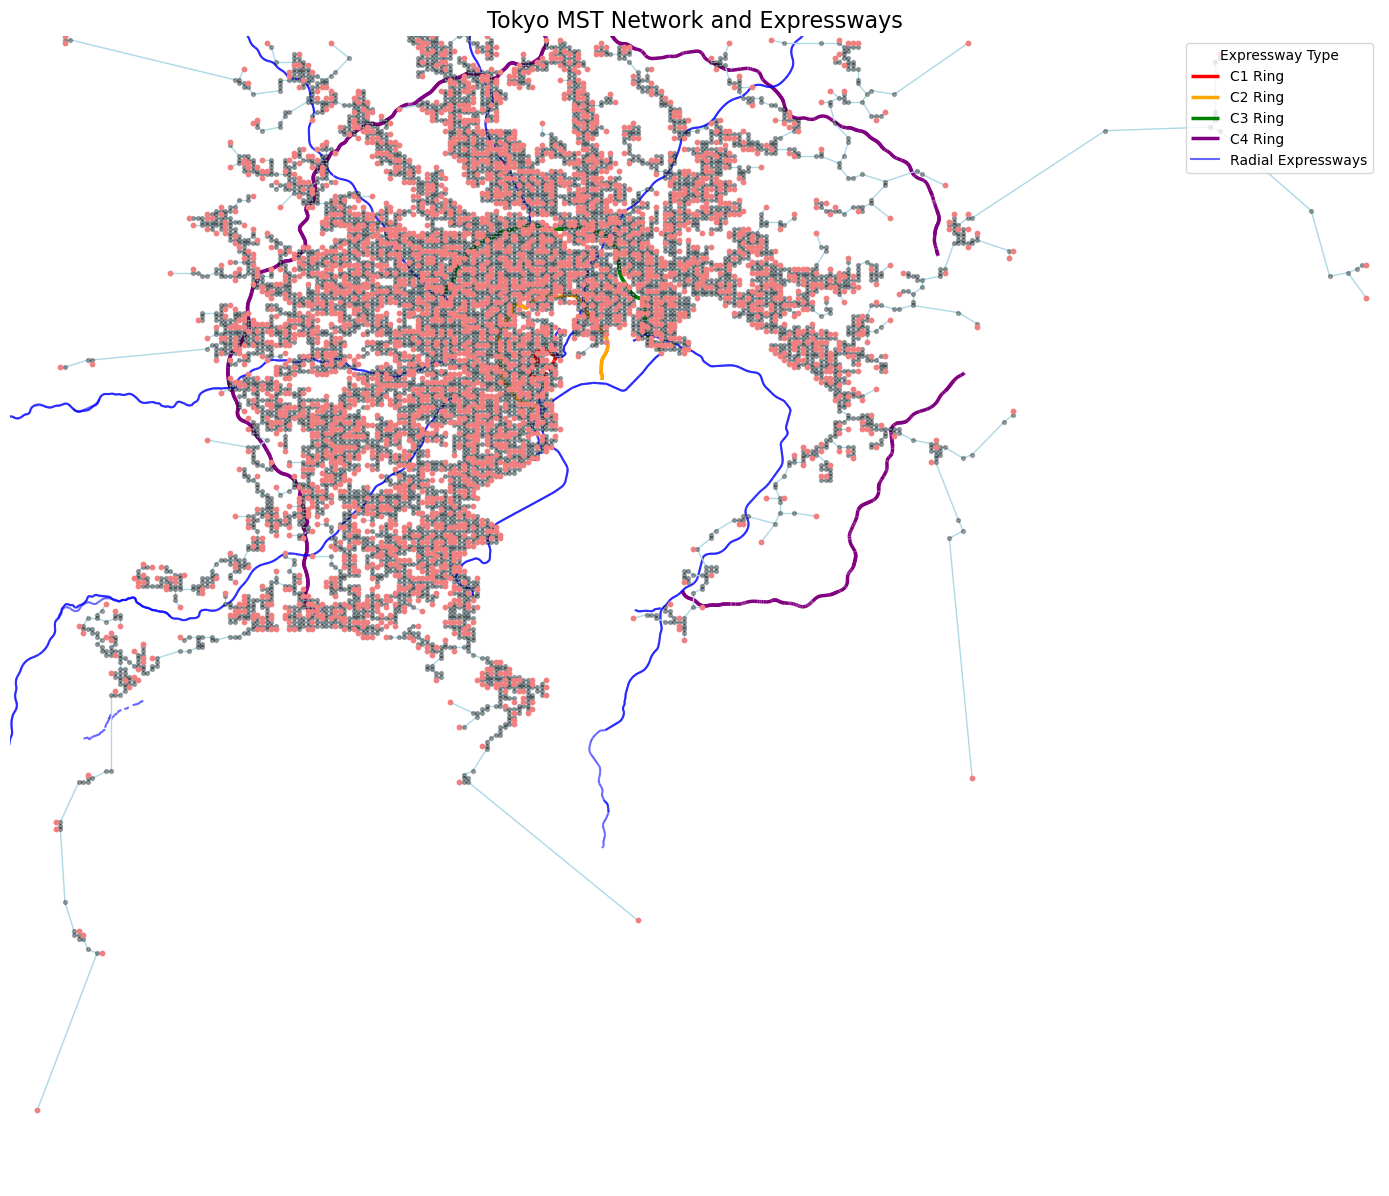

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import python_codes.files_operators as fo  # 自定义 .net 文件读取模块

# ===== 文件路径 =====
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"
mst_path = "./MST_net/tokyo_pop_500_mst.net"

# ===== 加载高速公路 GeoJSON 文件 =====
gdf_ring = gpd.read_file(ring_path)
gdf_ray = gpd.read_file(ray_path)
gdf_ring = gdf_ring[gdf_ring.geometry.notnull()]
gdf_ray = gdf_ray[gdf_ray.geometry.notnull()]


# ===== 分类四环并上色 =====
def classify_ring(ref):
    if isinstance(ref, list):
        ref = ref[0]
    if "C1" in ref:
        return "C1"
    elif "C2" in ref:
        return "C2"
    elif "C3" in ref:
        return "C3"
    elif "C4" in ref or "Ken-O" in ref or "圏央道" in ref:
        return "C4"
    return "Other"


gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# ===== 加载 .net 格式的 MST 网络 =====
read_graph, read_pos_raw = fo.read_files(mst_path)


# ===== 将平面坐标 (1360~1509.5, 1200~1358) 映射到东京区域经纬度 (138.9~141.1, 34.6~36.1) =====
def project_mst_coords_to_latlon(read_pos_raw, graph):
    # 平面坐标范围（来自分析）
    x_min, x_max = 1360.0, 1509.5
    y_min, y_max = 1200.0, 1358.0

    # 经纬度范围（东京）
    lon_min, lon_max = 138.9, 141.1
    lat_min, lat_max = 34.6, 36.1

    projected = {}
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])
        lon = lon_min + (x - x_min) / (x_max - x_min) * (lon_max - lon_min)
        lat = lat_max - (y - y_min) / (y_max - y_min) * (lat_max - lat_min)  # ⬅ 反向映射
        projected[v] = (lon, lat)
    return projected


read_pos = project_mst_coords_to_latlon(read_pos_raw, read_graph)

# ===== 开始绘图 =====
fig, ax = plt.subplots(figsize=(14, 14))

# === 绘制环状高速 ===
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2.5, color=color, label=f"{ring_type} Ring")

# === 绘制放射状高速 ===
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6)
ax.plot([], [], color="blue", linewidth=1.5, alpha=0.6, label="Radial Expressways")

# === 绘制 MST 边（淡蓝色） ===
for edge in read_graph.edges():
    src = read_pos[edge.source()]
    tgt = read_pos[edge.target()]
    ax.plot([src[0], tgt[0]], [src[1], tgt[1]], color="lightblue", linewidth=1.0, zorder=2)

# === 找出叶节点（度为1） ===
leaf_nodes = [v for v in read_graph.vertices() if v.out_degree() == 1]

# === 绘制叶节点（淡红色） ===
for v in leaf_nodes:
    x, y = read_pos[v]
    ax.scatter(x, y, color="lightcoral", s=10, zorder=3)

# === 绘制其他节点（黑色半透明） ===
for v in read_graph.vertices():
    if v not in leaf_nodes:
        x, y = read_pos[v]
        ax.scatter(x, y, color="black", alpha=0.3, s=8, zorder=2)

# === 样式设置 ===
ax.set_title("Tokyo MST Network and Expressways", fontsize=16)
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
ax.set_axis_off()

# === 设置合适的显示范围（东京都 + 周边） ===
ax.set_xlim(138.9, 141.1)
ax.set_ylim(34.6, 36.1)

plt.tight_layout()
plt.savefig("tokyo_mst_ring_ray_overlay_aligned.png", dpi=300)
plt.show()


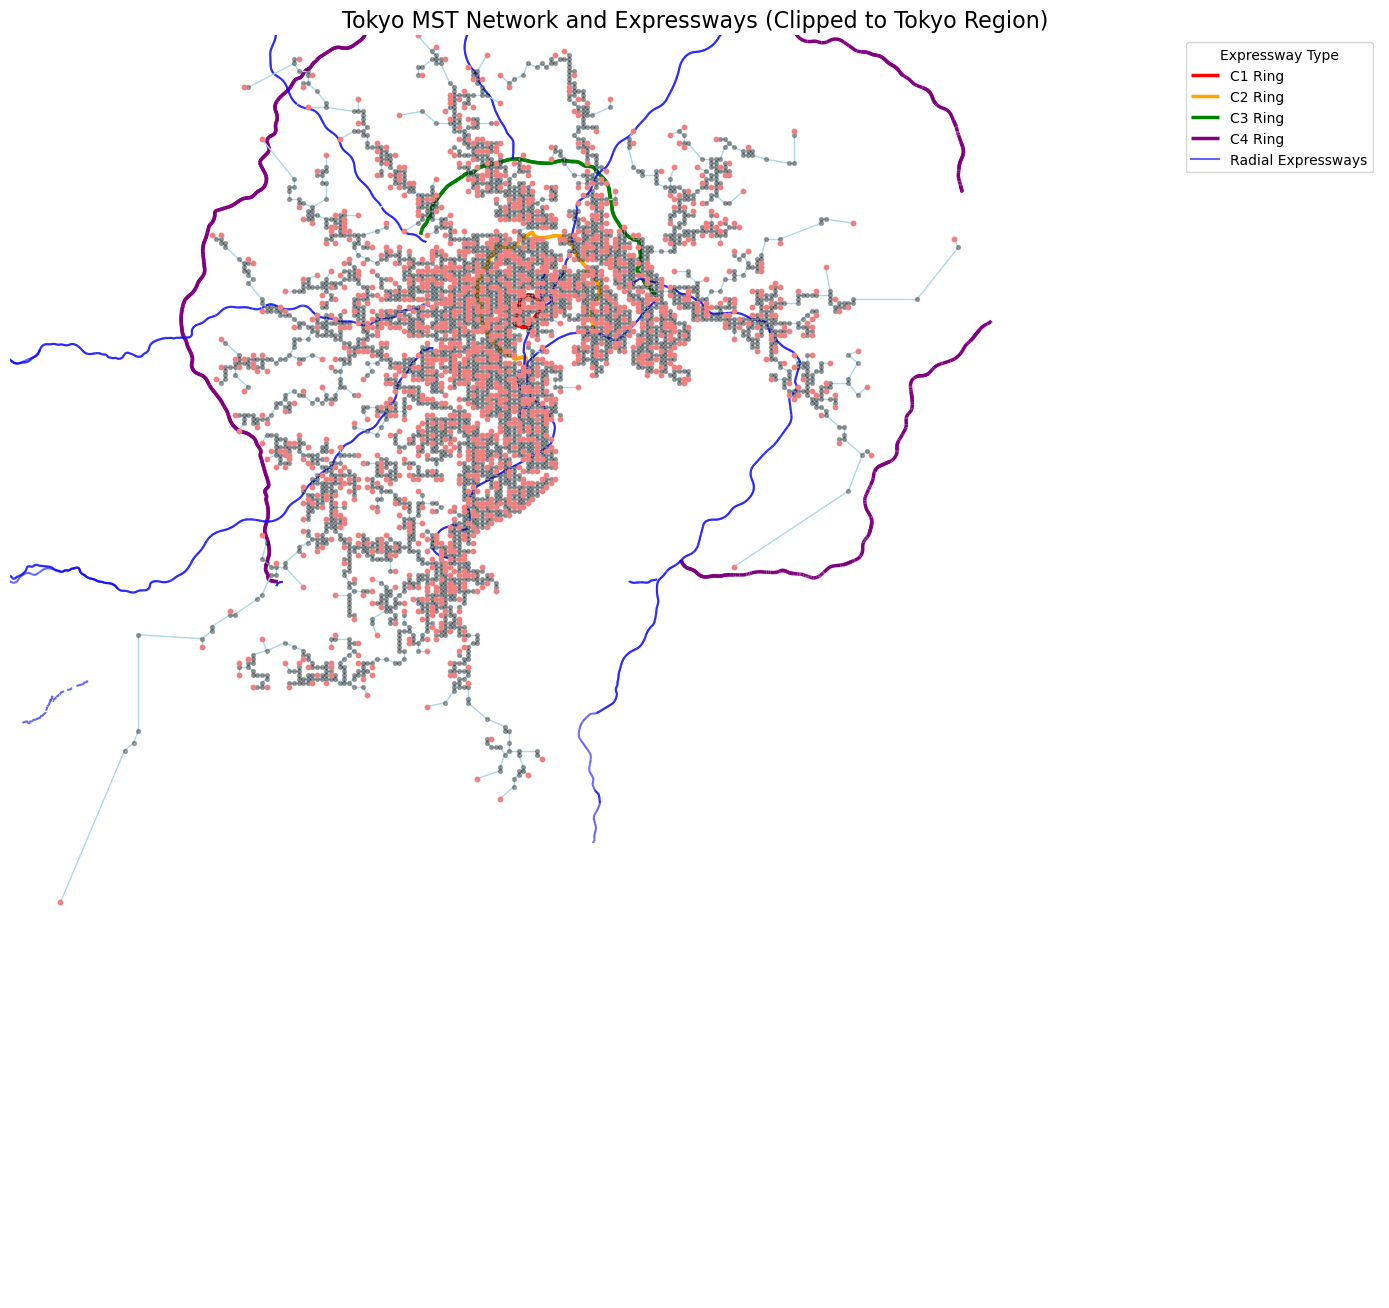

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
import python_codes.files_operators as fo  # 读取 .net 文件模块

# ===== 文件路径 =====
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"
mst_path = "./MST_net/tokyo_pop_5000_mst.net"

# ===== 经纬度裁剪范围（东京及周边）=====
bbox = box(139.0, 34.5, 141.0, 36.0)


def clip_geojson(path, bbox):
    gdf = gpd.read_file(path)
    gdf = gdf[gdf.geometry.notnull()]
    return gdf[gdf.geometry.intersects(bbox)]


gdf_ring = clip_geojson(ring_path, bbox)
gdf_ray = clip_geojson(ray_path, bbox)


# ===== 分类四环并上色 =====
def classify_ring(ref):
    if isinstance(ref, list): ref = ref[0]
    if "C1" in ref: return "C1"
    if "C2" in ref: return "C2"
    if "C3" in ref: return "C3"
    if "C4" in ref or "Ken-O" in ref or "圏央道" in ref: return "C4"
    return "Other"


gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# ===== 加载 MST 网络数据 =====
read_graph, read_pos_raw = fo.read_files(mst_path)


# ===== 将原始坐标映射为经纬度（更准确）=====
def project_mst_coords_to_latlon(read_pos_raw, graph):
    # 原始平面坐标范围（从数据分析得出）
    x_min, x_max = 1360.0, 1509.5
    y_min, y_max = 1200.0, 1358.0

    # 目标经纬度范围（东京都及周边）
    lon_min, lon_max = 139.0, 141.0
    lat_min, lat_max = 34.5, 36.0

    projected = {}
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])
        lon = lon_min + (x - x_min) / (x_max - x_min) * (lon_max - lon_min)
        lat = lat_max - (y - y_min) / (y_max - y_min) * (lat_max - lat_min)  # y轴反向
        projected[v] = (lon, lat)
    return projected


read_pos = project_mst_coords_to_latlon(read_pos_raw, read_graph)

# ===== 绘图开始 =====
fig, ax = plt.subplots(figsize=(14, 14))

# === 绘制四环 ===
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2.5, color=color, label=f"{ring_type} Ring")

# === 绘制放射状高速 ===
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6)
ax.plot([], [], color="blue", linewidth=1.5, alpha=0.6, label="Radial Expressways")

# === 绘制 MST 边（淡蓝色） ===
for edge in read_graph.edges():
    src = read_pos[edge.source()]
    tgt = read_pos[edge.target()]
    ax.plot([src[0], tgt[0]], [src[1], tgt[1]], color="lightblue", linewidth=1.0, zorder=2)

# === 找出叶节点 ===
leaf_nodes = [v for v in read_graph.vertices() if v.out_degree() == 1]

# === 绘制叶节点（淡红色） ===
for v in leaf_nodes:
    x, y = read_pos[v]
    ax.scatter(x, y, color="lightcoral", s=10, zorder=3)

# === 绘制其他节点（黑色半透明） ===
for v in read_graph.vertices():
    if v not in leaf_nodes:
        x, y = read_pos[v]
        ax.scatter(x, y, color="black", alpha=0.3, s=8, zorder=2)

# === 样式设置 ===
ax.set_title("Tokyo MST Network and Expressways (Clipped to Tokyo Region)", fontsize=16)
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
ax.set_axis_off()
ax.set_xlim(139.0, 141.0)
ax.set_ylim(34.5, 36.0)

plt.tight_layout()
plt.savefig("tokyo_mst_ring_ray_overlay_clipped-5000.png", dpi=300)
plt.show()


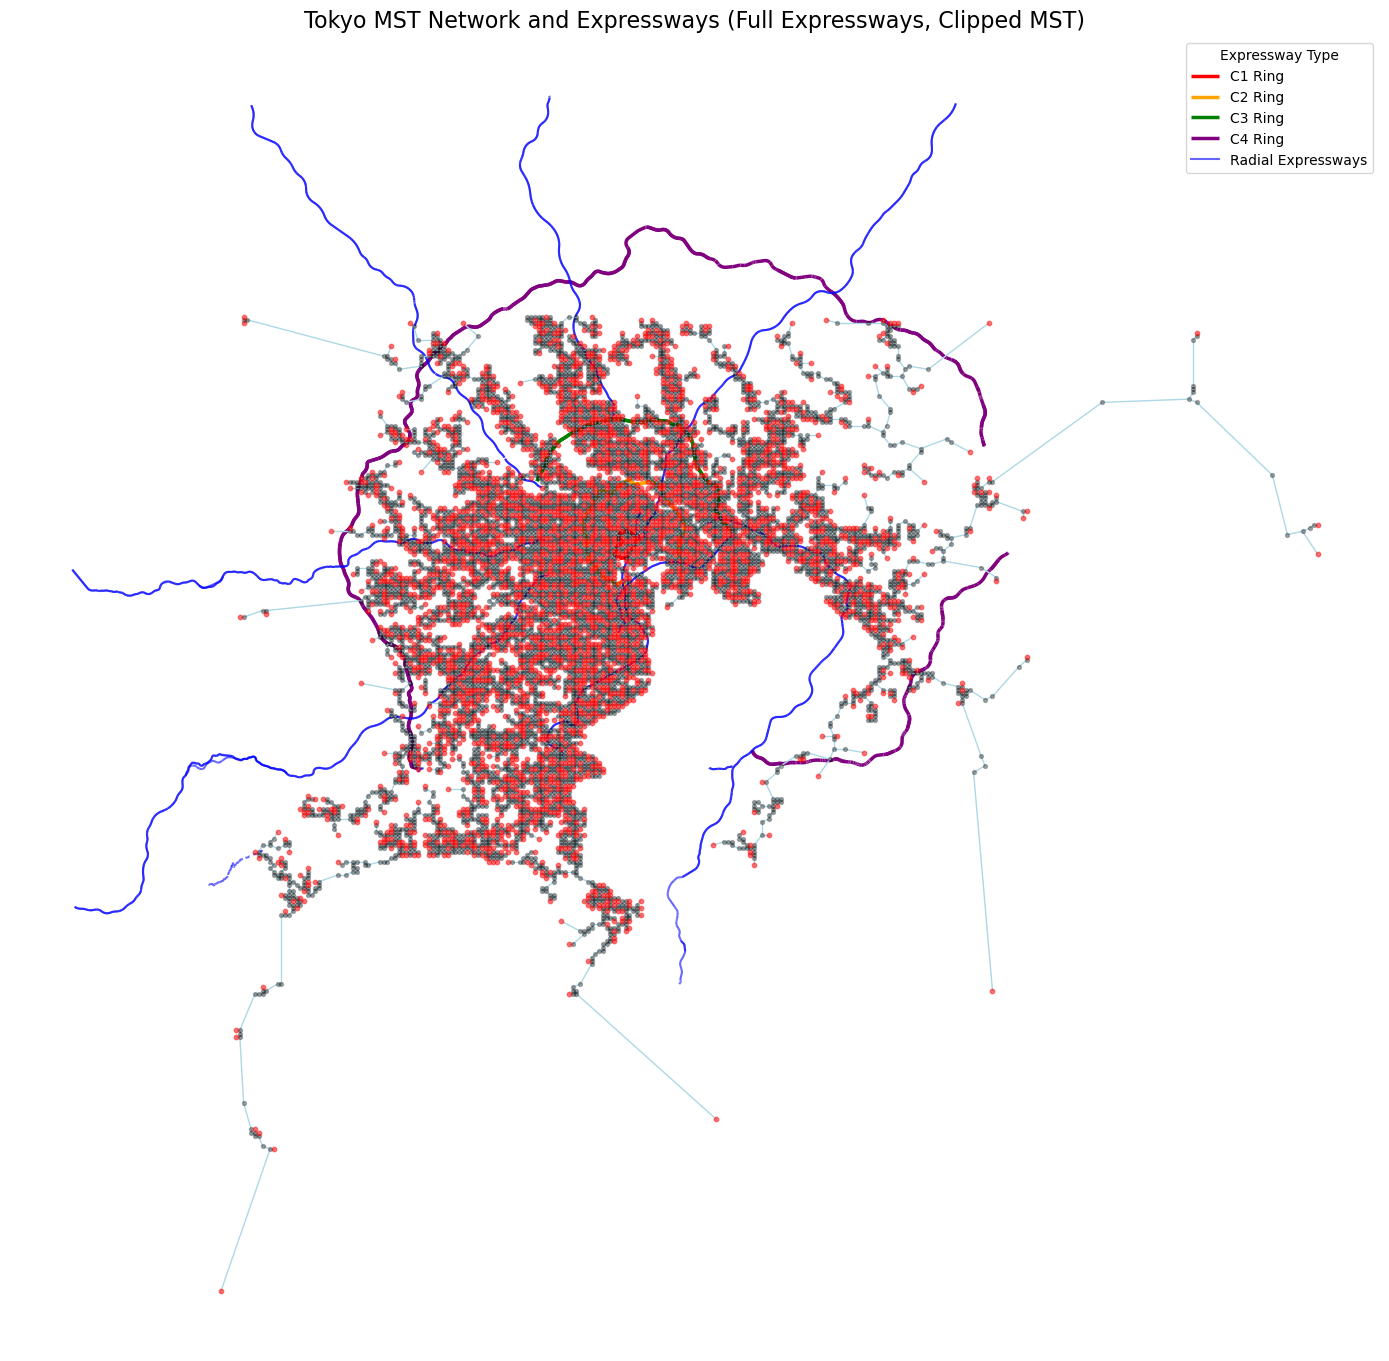

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import python_codes.files_operators as fo  # 自定义 .net 文件读取模块

# ===== 文件路径 =====
ring_path = "./tokyo_4ring.geojson"
ray_path = "./tokyo_9ray.geojson"
mst_path = "./MST_net/tokyo_pop_10000_mst.net"

# ===== 加载高速公路数据（保留完整，不做裁剪）=====
gdf_ring = gpd.read_file(ring_path)
gdf_ray = gpd.read_file(ray_path)
gdf_ring = gdf_ring[gdf_ring.geometry.notnull()]
gdf_ray = gdf_ray[gdf_ray.geometry.notnull()]


# ===== 分类四环并上色 =====
def classify_ring(ref):
    if isinstance(ref, list): ref = ref[0]
    if "C1" in ref: return "C1"
    if "C2" in ref: return "C2"
    if "C3" in ref: return "C3"
    if "C4" in ref or "Ken-O" in ref or "圏央道" in ref: return "C4"
    return "Other"


gdf_ring["ring_type"] = gdf_ring["ref"].astype(str).apply(classify_ring)
ring_color_map = {
    "C1": "red",
    "C2": "orange",
    "C3": "green",
    "C4": "purple"
}
gdf_ring["color"] = gdf_ring["ring_type"].map(ring_color_map)

# ===== 加载 MST 网络 =====
read_graph, read_pos_raw = fo.read_files(mst_path)


# ===== 精确地将原始坐标映射为经纬度 =====
def project_mst_coords_to_latlon(read_pos_raw, graph):
    # 原始坐标范围
    x_min, x_max = 1360.0, 1509.5
    y_min, y_max = 1200.0, 1358.0

    # 经纬度范围（只对 MST 使用）
    lon_min, lon_max = 139.0, 141.0
    lat_min, lat_max = 34.5, 36.0

    projected = {}
    for v in graph.vertices():
        x, y = tuple(read_pos_raw[v])
        lon = lon_min + (x - x_min) / (x_max - x_min) * (lon_max - lon_min)
        lat = lat_max - (y - y_min) / (y_max - y_min) * (lat_max - lat_min)
        projected[v] = (lon, lat)
    return projected


read_pos = project_mst_coords_to_latlon(read_pos_raw, read_graph)

# ===== 开始绘图 =====
fig, ax = plt.subplots(figsize=(14, 14))

# === 绘制四环 ===
for ring_type, color in ring_color_map.items():
    subset = gdf_ring[gdf_ring["ring_type"] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2.5, color=color, label=f"{ring_type} Ring")

# === 绘制放射状高速 ===
gdf_ray.plot(ax=ax, linewidth=1.5, color="blue", alpha=0.6)
ax.plot([], [], color="blue", linewidth=1.5, alpha=0.6, label="Radial Expressways")

# === 绘制 MST 边（淡蓝色） ===
for edge in read_graph.edges():
    src = read_pos[edge.source()]
    tgt = read_pos[edge.target()]
    ax.plot([src[0], tgt[0]], [src[1], tgt[1]], color="lightblue", linewidth=1.0, zorder=2)

# === 找出叶节点（度为1） ===
leaf_nodes = [v for v in read_graph.vertices() if v.out_degree() == 1]

# === 绘制叶节点（淡红色） ===
for v in leaf_nodes:
    x, y = read_pos[v]
    ax.scatter(x, y, color="red", alpha=0.5, s=10, zorder=3)

# === 绘制其他节点（黑色半透明） ===
for v in read_graph.vertices():
    if v not in leaf_nodes:
        x, y = read_pos[v]
        ax.scatter(x, y, color="black", alpha=0.3, s=8, zorder=2)

# === 样式设置 ===
ax.set_title("Tokyo MST Network and Expressways (Full Expressways, Clipped MST)", fontsize=16)
ax.legend(loc="upper right", fontsize=10, title="Expressway Type")
ax.set_axis_off()

# === 设置地图显示范围为东京区域 ===
plt.tight_layout()
plt.savefig("tokyo_mst_ring_ray_overlay_clippedMST_fullRoads10000.png", dpi=600)
plt.show()
